In [1]:
import numpy as np
import pandas as pd

import strawb
import strawb.sensors.camera as camera
import os
import matplotlib.pyplot as plt

# Load files from the ONC server
Be careful, depending on the amount of data this can take a while!!

In [2]:
# load DB
db = strawb.SyncDBHandler(file_name='Default')  # loads the db
db.load_onc_db_update(save_db=True)  # update the DB, could take some time if it has to load info. from ONC

Print some info from the DB

In [3]:
print(db.dataframe.columns)

### these are the available device codes
print(db.dataframe.deviceCode.unique())

### different measurement types for PMTSPEC and LIDAR, 
# works only if hdf5 attributes are imported from files on disc
#print(db.dataframe.measurement_type.unique())

### these are the parts of each module that produce data
print(db.dataframe.dataProductCode.unique())

Index([       'archiveLocation',           'archivedDate',
                  'compression',        'dataProductCode',
                     'dateFrom',                 'dateTo',
                   'deviceCode',               'fileSize',
                     'filename',             'modifyDate',
                         'path',   'uncompressedFileSize',
                      'outPath',               'fullPath',
                       'synced',               'h5_attrs',
                     'dev_code',               'file_end',
                      'file_id',             'file_start',
            'following_file_id',                   'name',
             'previous_file_id',      'rollover_interval',
                      'run_end',              'run_start',
                 'write_period',    'write_period_jitter',
             'measurement_type',   'measurement_duration',
            'laser_position_x0',      'laser_position_y0',
            'measurement_steps', 'measurement_step_width

### Select (a) file(s) of interest

In [4]:
mask = (db.dataframe.deviceCode == 'TUMPMTSPECTROMETER001') # that's the pmtspec module
mask &= (db.dataframe.dataProductCode =='MSSCD') # that's the camera data of the pmtspec module

## select the file for the biolumi event with a window of +- 5 hours
timestamp = pd.Timestamp('2022-03-04T23:44:09', tz='UTC')
mask &= db.dataframe.dateFrom >= timestamp - pd.Timedelta('5H')  # - 5 hours
mask &= db.dataframe.dateFrom <= timestamp + pd.Timedelta('5H')  # - 5 hours

### selected one file from the DB (it's the same as the file we selected above by hand)
db.dataframe[mask]

,archiveLocation,archivedDate,compression,dataProductCode,dateFrom,dateTo,deviceCode,fileSize,filename,modifyDate,...,measurement_subtype,file_version,dt_step,lower_threshold,lower_threshold_hv,step_size,step_size_hv,upper_threshold,upper_threshold_hv,0
fullPath,,,,,,,,,,,,,,,,,,,,,
/Users/kilian/PycharmProjects/strawb_package/raw_module_data/tumpmtspectrometer001/2022_03/TUMPMTSPECTROMETER001_20220304T190000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_05,2022-03-05 01:46:29.671000+00:00,None,MSSCD,2022-03-04 19:00:00+00:00,2022-03-04 19:59:59.999000+00:00,TUMPMTSPECTROMETER001,52316392,TUMPMTSPECTROMETER001_20220304T190000.000Z-SDA...,2022-03-05 01:46:31.341000+00:00,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'dev_code': 'TUMPMTSPECTROMETER001', 'file_en..."
/Users/kilian/PycharmProjects/strawb_package/raw_module_data/tumpmtspectrometer001/2022_03/TUMPMTSPECTROMETER001_20220304T200000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_05,2022-03-05 01:46:27.982000+00:00,None,MSSCD,2022-03-04 20:00:00+00:00,2022-03-04 20:59:59.999000+00:00,TUMPMTSPECTROMETER001,49130052,TUMPMTSPECTROMETER001_20220304T200000.000Z-SDA...,2022-03-05 01:46:29.609000+00:00,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'dev_code': 'TUMPMTSPECTROMETER001', 'file_en..."
/Users/kilian/PycharmProjects/strawb_package/raw_module_data/tumpmtspectrometer001/2022_03/TUMPMTSPECTROMETER001_20220304T210000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_05,2022-03-05 01:46:24.499000+00:00,None,MSSCD,2022-03-04 21:00:00+00:00,2022-03-04 21:59:59.999000+00:00,TUMPMTSPECTROMETER001,52310319,TUMPMTSPECTROMETER001_20220304T210000.000Z-SDA...,2022-03-05 01:46:26.090000+00:00,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'dev_code': 'TUMPMTSPECTROMETER001', 'file_en..."
/Users/kilian/PycharmProjects/strawb_package/raw_module_data/tumpmtspectrometer001/2022_03/TUMPMTSPECTROMETER001_20220304T220000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_05,2022-03-05 01:46:21.711000+00:00,None,MSSCD,2022-03-04 22:00:00+00:00,2022-03-04 22:59:59.999000+00:00,TUMPMTSPECTROMETER001,50898019,TUMPMTSPECTROMETER001_20220304T220000.000Z-SDA...,2022-03-05 01:46:23.371000+00:00,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'dev_code': 'TUMPMTSPECTROMETER001', 'file_en..."
/Users/kilian/PycharmProjects/strawb_package/raw_module_data/tumpmtspectrometer001/2022_03/TUMPMTSPECTROMETER001_20220304T230000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_05,2022-03-05 01:46:18.943000+00:00,None,MSSCD,2022-03-04 23:00:00+00:00,2022-03-04 23:59:59.999000+00:00,TUMPMTSPECTROMETER001,49487640,TUMPMTSPECTROMETER001_20220304T230000.000Z-SDA...,2022-03-05 01:46:20.611000+00:00,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'dev_code': 'TUMPMTSPECTROMETER001', 'file_en..."
/Users/kilian/PycharmProjects/strawb_package/raw_module_data/tumpmtspectrometer001/2022_03/TUMPMTSPECTROMETER001_20220305T000000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_05,2022-03-05 01:46:15.568000+00:00,None,MSSCD,2022-03-05 00:00:00+00:00,2022-03-05 00:59:59.999000+00:00,TUMPMTSPECTROMETER001,51962323,TUMPMTSPECTROMETER001_20220305T000000.000Z-SDA...,2022-03-05 01:46:18.867000+00:00,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'dev_code': 'TUMPMTSPECTROMETER001', 'file_en..."
/Users/kilian/PycharmProjects/strawb_package/raw_module_data/tumpmtspectrometer001/2022_03/TUMPMTSPECTROMETER001_20220305T010000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_05,2022-03-06 01:41:06.059000+00:00,None,MSSCD,2022-03-05 01:00:00+00:00,2022-03-05 01:59:59.999000+00:00,TUMPMTSPECTROMETER001,50901243,TUMPMTSPECTROMETER001_20220305T010000.000Z-SDA...,2022-03-06 01:41:07.245000+00:00,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'dev_code': 'TUMPMTSPECTROMETER001', 'file_en..."
/Users/kilian/PycharmProjects/strawb_package/raw_module_data/tumpmtspectrometer001/2022_03/TUMPMTSPECTROMETER001_20220305T020000.000Z-SDAQ-CAMERA.hdf5,/NA_Archive_05,2022-03-06 01:40:53.975000+00:00,None,MSSCD,2022-03-05 02:00:00+00:00,2022-03-05 02:59:59.999000+00:00,TUMPMTSPECTROMETER001,49472282,TUMPMTSPECTROMETER001_20220305T020000.000Z-SDA...,2022-03-06 01:40:55.061000+00:00,...,NaN,

### Download the missing files which aren't synced so far from `db.dataframe[mask]`

In [5]:
if not db.dataframe.synced[mask].all():
    db.update_db_and_load_files(
        db.dataframe[mask],
        output=True,  # print output to console
        download=True,  # download the files
        save_db=True,
    )  # update the DB

# Import the file to the Camera Module 

In [6]:
# select the Camera file(s) -> dataProductCode == 'MSSCD'
item = db.dataframe[mask & (db.dataframe.dataProductCode =='MSSCD')]

try: # if the pmtspec file is still open
    camera.file_handler.close()
except:
    pass
    
# generate a virtual hdf5 to combine the datasets if there are multiple files selected
if len(item) > 1:
    vhdf5 = strawb.VirtualHDF5('MSSCD_event_view.hdf5', item.fullPath.to_list())  
    file_name = vhdf5.file_name
else:
    file_name = item.fullPath[0]

# create an instance of the Camera
camera = strawb.sensors.camera.Camera(file_name)

### Print some parameters

In [7]:
print(f'Module: {camera.file_handler.module}')
print(f'Number of Frames: {camera.file_handler.exposure_time.shape[0]}')
print(f'Date: {np.min(camera.file_handler.time.asdatetime()[:])} - {np.max(camera.file_handler.time.asdatetime()[:])}')
print(f'Exposure Times [s]: {np.unique(camera.file_handler.exposure_time)}')

Module: TUMPMTSPECTROMETER001
Number of Frames: 360
Date: 2022-03-04T19:00:00.717591 - 2022-03-05T04:57:19.181483
Exposure Times [s]: [52.5]


### Mask images to export (here only one)

In [8]:
# may take some time, if the time period isn't changed, index 170 is the bright event
if False:
    # mask over a threshold + mask invalid frames + mask no lucifer enabled
    mask = (camera.images.integrated_minus_dark > 1e6) & camera.images.invalid_mask

    index = np.argsort(camera.images.integrated_minus_dark)  # sort by charge [min,...,max]
    index = index[mask[index]]  # remove invalid items  & cam_module.invalid_mask
    index = index[::-1]  # revers the order
else:
    index = [170]
print(index)

[170]


## Show one image here

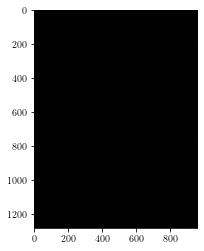

In [11]:
plt.figure()
rgb = camera.images.load_rgb(index=index)
plt.imshow(rgb[0,:,:]/2**16)  # rgb[frame, row, col], /255 to get 0->1
plt.savefig("figures/biolumi_demo.pdf", backend="pdf")
plt.savefig("figures/biolumi_demo.png", dpi=120)

## How to access the raw data (numpy)

In [12]:
# The raw pixel values are NOT loaded by default to the module to save RAM.
# They can be accessed directly from the file with the index, index = None (default) to loads all images
a = camera.file_handler.raw[[1,3]]  # direct h5py access, allows only sorted (non-duplicate) index access.
print(a.shape)

a = camera.file_handler.raw.getunsorted([1,3])  # STRAWb helper to access it unsorted (and duplicate) by index
print(a.shape)

raw = camera.file_handler.raw[:]  # get all images
# returns array of images on default, even if only one element is accessed
print(f'raw shape: {raw.shape}') # shape of images, n_pic x 2D shape of picture
print(f'raw picture: {raw[0].shape}') # 2D shape of picture

raw = camera.images.cut2effective_pixel_arr(raw)
print(f'shape reduced to effective pixel: {raw[0].shape}') # 2D shape of picture

(2, 1297, 977)
(2, 1297, 977)
raw shape: (360, 1297, 977)
raw picture: (1297, 977)
shape reduced to effective pixel: (1280, 960)


# Now we have the raw-data with valid pixel range 

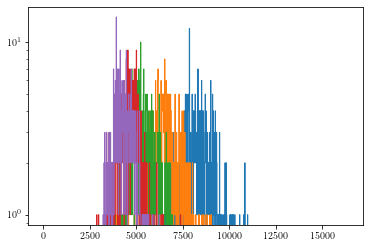

In [13]:
# plot the histogram for some pixel
bins = np.linspace(0, 2**14, 1000)
plt.figure()
for i in range(1,10,2):
    # pixel are selected with: 1200-50*i & 900-50*i
    plt.hist(raw[:, 1200-50*i, 900-50*i], bins=bins, histtype='step')

plt.yscale('log')
plt.show()